In [9]:
import os
import wave 
import langid
#import openai
import librosa
import sklearn
import pyaudio #python bindings for PortAudio the cross_platform audio i/o  library
import fasttext
import playsound
from gtts import gTTS
import librosa.display
from langdetect import detect
from pydub import AudioSegment
import matplotlib.pyplot as plt
import speech_recognition as sr
#from translate import Translator
from tempfile import NamedTemporaryFile
#from googletrans import Translator
from IPython.display import Audio, display
from transformers import MarianMTModel, MarianTokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from translate import Translator

# Ensure pydub can find the ffmpeg/ffprobe binary
AudioSegment.converter = "ffmpeg"  # path to ffmpeg binary

c=0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10d59ba10>>
Traceback (most recent call last):
  File "/Users/saraabdelhafid/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
#pip install translate
#wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
'''/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"
brew install ffmpeg
ffmpeg -version
'''

'/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"\nbrew install ffmpeg\nffmpeg -version\n'

## choose the microphone to be used from the device

#### Functions

In [ ]:
# choose_microphone
def choose_microphone():
    print("Available Microphones:")
    microphones = sr.Microphone.list_microphone_names()
    for i, mic in enumerate(microphones):
        print(f"{i}: {mic}")
    while True:
        choice = input("Enter the index or name of the microphone you want to use to record audio: ")
        if choice.isdigit():
            choice = int(choice)
            if 0 <= choice < len(microphones):
                print(f"The microphone used is {choice} : {microphones[choice]}.")
                return choice
        elif choice in microphones:
            print(f"The microphone used is {choice} : {microphones[choice]}.")
            return choice
        print("Invalid choice. Please enter a valid index or microphone name.")


# Function to translate "I'm Listening to you..." automatically
def listenit_message(text,language):
    translator = Translator(to_lang=language)

    try:
        # Translate using translate library
        translation = translator.translate(text)
        return translation
    except Exception as e:
        return f"Language not supported for translation: {str(e)}"


# save input audio wave
def save_input_audio(audio, c, save_dir="audio_in_out/inputs_audio"):
    # Ensure the directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Write wave file
    sample_rate = 48000.0  # Hertz
    frames = audio.get_wav_data()
    wav_filename = os.path.join(save_dir, f"input_audio_{c}.wav")
    with wave.open(wav_filename, 'w') as obj:
        obj.setnchannels(1)  # Mono or 2
        obj.setsampwidth(2)
        obj.setframerate(sample_rate)
        obj.writeframes(frames)
    
    print(f"Audio has been saved to: {wav_filename}")
    return wav_filename


# save output audio wave
def save_output_audio(audio, c, save_dir="audio_in_out/outputs_audio"):
    # Ensure the directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Write wave file
    sample_rate = 48000.0  # Hertz
    frames = audio.get_wav_data()
    wav_filename = os.path.join(save_dir, f"output_audio_{c}.wav")
    with wave.open(wav_filename, 'w') as obj:
        obj.setnchannels(1)  # Mono or 2
        obj.setsampwidth(2)
        obj.setframerate(sample_rate)
        obj.writeframes(frames)
    
    print(f"Audio has been saved to: {wav_filename}")
    return wav_filename


# save the INPUT text output in a file 
def input_text_to_file(text, c, save_dir="text_in_out/inputs_text"):
    file_path = os.path.join(save_dir, f"input_text_{c}.txt")
    with open(file_path, "a") as f:
        f.write(text + "\n")


# save the OUTPUT text output in a file 
def output_text_to_file(text, c, save_dir="text_in_out/outputs_text"):
    file_path = os.path.join(save_dir, f"output_text_{c}.txt")
    with open(file_path, "a") as f:
        f.write(text + "\n")


# record Speech and convert it to Text as input
def record_speech_to_text(chosen_microphone,c,language):
    recognizer = sr.Recognizer()
    #get audio and save it
    with sr.Microphone(device_index=chosen_microphone) as source:
        recognizer.adjust_for_ambient_noise(source)  # Adjust for noise
        translation=listenit_message("Hi I'm listening...",language)
        print(translation)
        '''if language=='en' :
            print("Listening...")
        elif language=='ar':
            print("...في الاستماع")
        elif language=='fr':
            print("écoute...")'''
        audio = recognizer.listen(source)
        # Save the captured audio to a WAV file
        wav_filename = save_input_audio(audio, c)

        # Play back the captured audio
        # play_audio(audio)
        if language=='ar':
            new_text= translit("I'm Listening...",language)# translit the input to the arabic language
            print(new_text)
    #convert audio to text
    try:
        # Use Google's speech recognition with language detection
        text = recognizer.recognize_google(audio, language=language) # Use Google's speech recognition and Specify language parameter for Arabic ('ar')
        print(text)
        input_text_to_file(text, c)
        return text
    except sr.UnknownValueError:
        print("Could not understand audio")
        return ""
    except sr.RequestError as e:
        print("Could not request results; {0}".format(e))
        return ""


# read the INPUT text from a file
def read_text_from_inputs(c,save_dir="text_in_out/inputs_text"):
    file_path = os.path.join(save_dir, f"input_text_{c}.txt")
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()


# read the OUTPUT text from a file
def read_text_from_outputs(c,save_dir="text_in_out/outputs_text"):
    file_path = os.path.join(save_dir, f"output_text_{c}.txt")
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()


# speak the text_output and save it in a file 
def text_to_speach_input(text, lang, c, audio_save_dir="audio_in_out/inputs_audio"):
    if not text:
        if lang == 'en':
            print("There is no text_to_speech conversion.")
        elif lang == 'ar':
            print(".لا يوجد نص للتحويل إلى كلام")
        elif lang == 'fr':
            print("Il n’y a pas de conversion texte-parole.")
        return

    # Ensure the directory exists
    if not os.path.exists(audio_save_dir):
        os.makedirs(audio_save_dir)
        
    # Generate the filename for the wav file
    wav_filename = os.path.join(audio_save_dir, f"input_audio_{c}.wav")

    # Convert text to speech and save directly as wav using a temporary mp3 file
    with NamedTemporaryFile(delete=True) as tmp_mp3:
        tts = gTTS(text=text, lang=lang)
        tts.save(tmp_mp3.name)

        # Convert the mp3 file to wav
        sound = AudioSegment.from_mp3(tmp_mp3.name)
        sound.export(wav_filename, format="wav")


    # Play the wav file
    playsound.playsound(wav_filename)

    print(f"The response audio has been saved to: {wav_filename}")


# speak the text_output and save it in a file 
def text_to_speach_output(text, lang, c, audio_save_dir="audio_in_out/outputs_audio"):
    if not text:
        if lang == 'en':
            print("There is no text_to_speech conversion.")
        elif lang == 'ar':
            print(".لا يوجد نص للتحويل إلى كلام")
        elif lang == 'fr':
            print("Il n’y a pas de conversion texte-parole.")
        return

    # Ensure the directory exists
    if not os.path.exists(audio_save_dir):
        os.makedirs(audio_save_dir)
        
    # Generate the filename for the wav file
    wav_filename = os.path.join(audio_save_dir, f"output_audio_{c}.wav")

    # Convert text to speech and save directly as wav using a temporary mp3 file
    with NamedTemporaryFile(delete=True) as tmp_mp3:
        tts = gTTS(text=text, lang=lang)
        tts.save(tmp_mp3.name)

        # Convert the mp3 file to wav
        sound = AudioSegment.from_mp3(tmp_mp3.name)
        sound.export(wav_filename, format="wav")


    # Play the wav file
    playsound.playsound(wav_filename)

    print(f"The response audio has been saved to: {wav_filename}")


# speak the text_output from a file and save it in an audio 
def text_to_speach_output_from_file(c, audio_save_dir="audio_in_out/outputs_audio"):#lang
    # Read the text from the file
    # Ensure the directory exists
    # Generate the filename for the wav file
    wav_filename = os.path.join(audio_save_dir, f"output_audio_file_{c}.wav")

    if not os.path.exists(audio_save_dir):
        os.makedirs(audio_save_dir)
    
    text = read_text_from_outputs(c)
    print(text)
    '''if not text:
        if lang == 'en':
            print("There is no text_to_speech conversion.")
        elif lang == 'ar':
            print(".لا يوجد نص للتحويل إلى كلام")
        elif lang == 'fr':
            print("Il n’y a pas de conversion texte-parole.")
        return'''
        
 
    # Convert text to speech and save directly as wav using a temporary mp3 file
    with NamedTemporaryFile(delete=True) as tmp_mp3:
        tts = gTTS(text=text, lang=lang)
        tts.save(tmp_mp3.name)

        # Convert the mp3 file to wav
        sound = AudioSegment.from_mp3(tmp_mp3.name)
        sound.export(wav_filename, format="wav")

    # Play the wav file
    playsound.playsound(wav_filename)

    print(f"The response audio has been saved to: {wav_filename}")

In [ ]:
'''# choose_microphone
def choose_microphone():
    print("Available Microphones:")
    microphones = sr.Microphone.list_microphone_names()
    for i, mic in enumerate(microphones):
        print(f"{i}: {mic}")
    while True:
        choice = input("Enter the index or name of the microphone you want to use to record audio: ")
        if choice.isdigit():
            choice = int(choice)
            if 0 <= choice < len(microphones):
                print(f"The microphone used is {choice} : {microphones[choice]}.")
                return choice
        elif choice in microphones:
            print(f"The microphone used is {choice} : {microphones[choice]}.")
            return choice
        print("Invalid choice. Please enter a valid index or microphone name.")'''
chosen_microphone = choose_microphone()
#print(mic)

Available Microphones:
0: Built-in Microphone
1: Built-in Output
2: Soundflower (2ch)
3: Soundflower (64ch)
4: Screenflick Loopback
5: iShowU Audio Capture
6: Périphérique agrégé
7: Périphérique à sortie multiple


The microphone used is 0 : Built-in Microphone.


In [ ]:
'''# save input audio function
def save_input_audio(audio, c, save_dir="audio_in_out/inputs_audio"):
    # Ensure the directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Write wave file
    sample_rate = 48000.0  # Hertz
    frames = audio.get_wav_data()
    wav_filename = os.path.join(save_dir, f"input_audio_{c}.wav")
    with wave.open(wav_filename, 'w') as obj:
        obj.setnchannels(1)  # Mono or 2
        obj.setsampwidth(2)
        obj.setframerate(sample_rate)
        obj.writeframes(frames)
    
    print(f"Audio has been saved to: {wav_filename}")
    return wav_filename'''

'def save_audio(audio,c):   \n# write wave file\n    sample_rate = 48000.0 #hertz\n    frames = audio.get_wav_data()\n    obj= wave.open(f"audio_wave_rec/quastion_rec{c}.wav",\'w\')# write  mode\n    obj.setnchannels(1)#mono\n    obj.setsampwidth(2)\n    obj.setframerate(sample_rate)\n    obj.writeframes(frames)\n    obj.close()'

In [ ]:
'''# save output audio function
def save_output_audio(audio, c, save_dir="audio_in_out/outputs_audio"):
    # Ensure the directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Write wave file
    sample_rate = 48000.0  # Hertz
    frames = audio.get_wav_data()
    wav_filename = os.path.join(save_dir, f"output_audio_{c}.wav")
    with wave.open(wav_filename, 'w') as obj:
        obj.setnchannels(1)  # Mono or 2
        obj.setsampwidth(2)
        obj.setframerate(sample_rate)
        obj.writeframes(frames)
    
    print(f"Audio has been saved to: {wav_filename}")
    return wav_filename'''


In [ ]:
'''#play audio function
def play_audio(audio):
    audio_data = audio.get_wav_data()
    with wave.open("temp_audio.wav", "wb") as f:
        f.setnchannels(1)
        f.setsampwidth(pyaudio.PyAudio().get_sample_size(pyaudio.paInt16))
        f.setframerate(16000)
        f.writeframes(audio_data)
        
    # Open the temporary WAV file and play it
    p = pyaudio.PyAudio()
    wf = wave.open("temp_audio.wav", "rb")# read byte mode
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(1024)
    while data:
        stream.write(data)
        data = wf.readframes(1024)
    stream.stop_stream()
    stream.close()

    p.terminate()'''

In [ ]:
'''# record Speech and convert it to Text as input
def record_text(chosen_microphone,c,language):
    recognizer = sr.Recognizer()
    #get audio and save it
    with sr.Microphone(device_index=chosen_microphone) as source:
        recognizer.adjust_for_ambient_noise(source)  # Adjust for noise
        if language=='en' :
            print("Listening...")
        elif language=='ar':
            print("...في الاستماع")
        elif language=='fr':
            print("écoute...")
        audio = recognizer.listen(source)
        # Save the captured audio to a WAV file
        wav_filename = save_input_audio(audio, c)
        # Play back the captured audio
        # play_audio(audio)

    #convert audio to text
    try:
        # Use Google's speech recognition with language detection
        text = recognizer.recognize_google(audio, language=language) # Use Google's speech recognition and Specify language parameter for Arabic ('ar')
        print(text)
        return text
    except sr.UnknownValueError:
        print("Could not understand audio")
        return ""
    except sr.RequestError as e:
        print("Could not request results; {0}".format(e))
        return ""
#text = record_text(chosen_microphone,c+2,'ar')'''

In [ ]:
'''# save the INPUT text output in a file 
def input_text_to_file(text, c, save_dir="text_in_out/inputs_text"):
    file_path = os.path.join(save_dir, f"input_text_{c}.txt")
    with open(file_path, "a") as f:
        f.write(text + "\n")
#input_text_to_file("كم اصبع يد القط", 0)'''

In [ ]:
'''# save the OUTPUT text output in a file 
def output_text_to_file(text, c, save_dir="text_in_out/outputs_text"):
    file_path = os.path.join(save_dir, f"output_text_{c}.txt")
    with open(file_path, "a") as f:
        f.write(text + "\n")
#output_text_to_file("3 اصابع",0)'''

In [ ]:
'''# read the INPUT text from a file
def read_text_from_inputs(c,save_dir="text_in_out/inputs_text"):
    file_path = os.path.join(save_dir, f"input_text_{c}.txt")
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()
#read_text_from_inputs(0)'''

'كم اصبع يد القط\n'

In [ ]:
'''# read the OUTPUT text from a file
def read_text_from_outputs(c,save_dir="text_in_out/outputs_text"):
    file_path = os.path.join(save_dir, f"output_text_{c}.txt")
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()
#read_text_from_outputs(0)'''

'3 اصابع\n'

In [ ]:
'''# speak the text_output and save it in a file 
def text_to_speach_input(text, lang, c, audio_save_dir="audio_in_out/inputs_audio"):
    if not text:
        if lang == 'en':
            print("There is no text_to_speech conversion.")
        elif lang == 'ar':
            print(".لا يوجد نص للتحويل إلى كلام")
        elif lang == 'fr':
            print("Il n’y a pas de conversion texte-parole.")
        return

    # Ensure the directory exists
    if not os.path.exists(audio_save_dir):
        os.makedirs(audio_save_dir)
        
    # Generate the filename for the wav file
    wav_filename = os.path.join(audio_save_dir, f"input_audio_{c}.wav")

    # Convert text to speech and save directly as wav using a temporary mp3 file
    with NamedTemporaryFile(delete=True) as tmp_mp3:
        tts = gTTS(text=text, lang=lang)
        tts.save(tmp_mp3.name)

        # Convert the mp3 file to wav
        sound = AudioSegment.from_mp3(tmp_mp3.name)
        sound.export(wav_filename, format="wav")


    # Play the wav file
    playsound.playsound(wav_filename)

    print(f"The response audio has been saved to: {wav_filename}")

# Example usage
text = "مرحبا يا سبيتشي كيف حالك اليوم"
lang = "ar"
text_to_speach_input(text, lang, 0)'''  

The response audio has been saved to: audio_in_out/inputs_audio/input_audio_0.wav


In [ ]:
'''# speak the text_output and save it in a file 
def text_to_speach_output(text, lang, c, audio_save_dir="audio_in_out/outputs_audio"):
    if not text:
        if lang == 'en':
            print("There is no text_to_speech conversion.")
        elif lang == 'ar':
            print(".لا يوجد نص للتحويل إلى كلام")
        elif lang == 'fr':
            print("Il n’y a pas de conversion texte-parole.")
        return

    # Ensure the directory exists
    if not os.path.exists(audio_save_dir):
        os.makedirs(audio_save_dir)
        
    # Generate the filename for the wav file
    wav_filename = os.path.join(audio_save_dir, f"output_audio_{c}.wav")

    # Convert text to speech and save directly as wav using a temporary mp3 file
    with NamedTemporaryFile(delete=True) as tmp_mp3:
        tts = gTTS(text=text, lang=lang)
        tts.save(tmp_mp3.name)

        # Convert the mp3 file to wav
        sound = AudioSegment.from_mp3(tmp_mp3.name)
        sound.export(wav_filename, format="wav")


    # Play the wav file
    playsound.playsound(wav_filename)

    print(f"The response audio has been saved to: {wav_filename}")

# Example usage
#text = "مرحبا يا سبيتشي كيف حالك اليوم"
#lang = "ar"
#text_to_speach_output(text, lang, 0)'''

The response audio has been saved to: audio_in_out/outputs_audio/output_audio_0.wav


In [ ]:
'''# speak the text_output from a file and save it in an audio 
def text_to_speach_output_from_file(c, audio_save_dir="audio_in_out/outputs_audio"):#lang
    # Read the text from the file
    # Ensure the directory exists
    # Generate the filename for the wav file
    wav_filename = os.path.join(audio_save_dir, f"output_audio_file_{c}.wav")

    if not os.path.exists(audio_save_dir):
        os.makedirs(audio_save_dir)
    
    text = read_text_from_outputs(c)
    print(text)
    ' ''if not text:
        if lang == 'en':
            print("There is no text_to_speech conversion.")
        elif lang == 'ar':
            print(".لا يوجد نص للتحويل إلى كلام")
        elif lang == 'fr':
            print("Il n’y a pas de conversion texte-parole.")
        return'' '
        
 
    # Convert text to speech and save directly as wav using a temporary mp3 file
    with NamedTemporaryFile(delete=True) as tmp_mp3:
        tts = gTTS(text=text, lang=lang)
        tts.save(tmp_mp3.name)

        # Convert the mp3 file to wav
        sound = AudioSegment.from_mp3(tmp_mp3.name)
        sound.export(wav_filename, format="wav")

    # Play the wav file
    playsound.playsound(wav_filename)

    print(f"The response audio has been saved to: {wav_filename}")

# Example usage
#file_path = "text_in_out/outputs_text"  
#lang = "ar"
#c = 2  # Example count
#text_to_speach_output_from_file(c-1)#lang'''

3 اصابع



The response audio has been saved to: audio_in_out/outputs_audio/response0.wav


In [ ]:
#chosen_microphone = choose_microphone()
#while c<=5:#while True

#get_input
input_text = record_text(chosen_microphone,c,language='ar')

#speech_to_text()

output_text_to_file(text)
print(f"Recorded text {c}:", text)


print(f"Generating Output {c}:", output_text)
text_to_speach_output_from_file(c)



c += 1


Available Microphones:
0: i12
1: i12
2: Built-in Microphone
3: Built-in Output
4: Soundflower (2ch)
5: Soundflower (64ch)
6: Screenflick Loopback
7: iShowU Audio Capture
8: Périphérique agrégé
9: Périphérique à sortie multiple
Listening...
كيف حالك هل انت بخير
Recorded text 5: كيف حالك هل انت بخير


In [ ]:
path= f"audio_wave_rec/output_rec{0}.wav"
display(Audio(path))

In [ ]:

#open wave file
obj = wave.open(path,'r')# read mode

print("number of channels", obj.getnchannels())
print("sample width", obj.getsampwidth())
print("frame rate", obj.getframerate())
print("number of frames", obj.getnframes())
print("parameters", obj.getparams())
frames = obj.readframes(obj.getnframes())
obj.close()



number of channels 1
sample width 2
frame rate 48000
number of frames 72726
parameters _wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=72726, comptype='NONE', compname='not compressed')


In [ ]:
data, sr = librosa.load(path, sr=48000) #sample rate
print(data.shape, sr)

(72726,) 48000


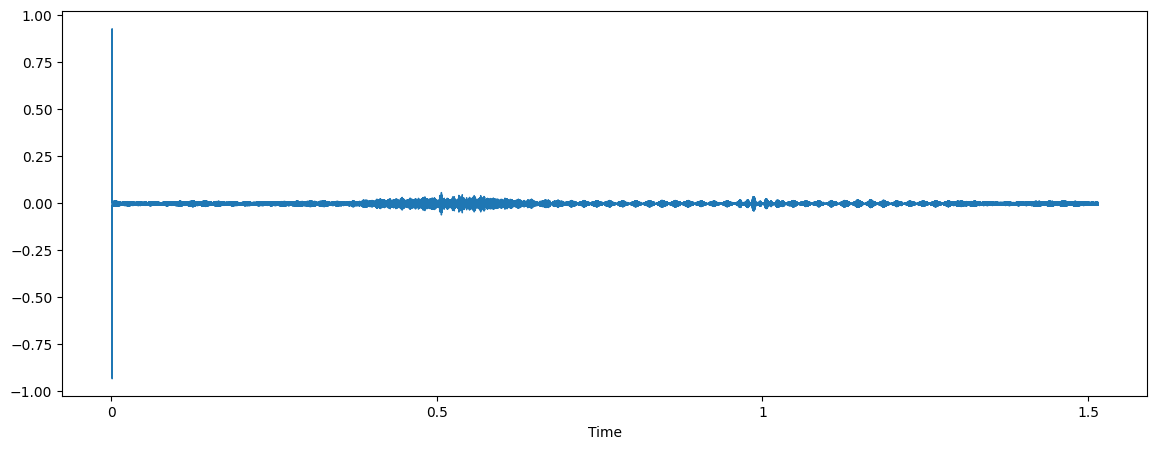

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(data, sr=sr)

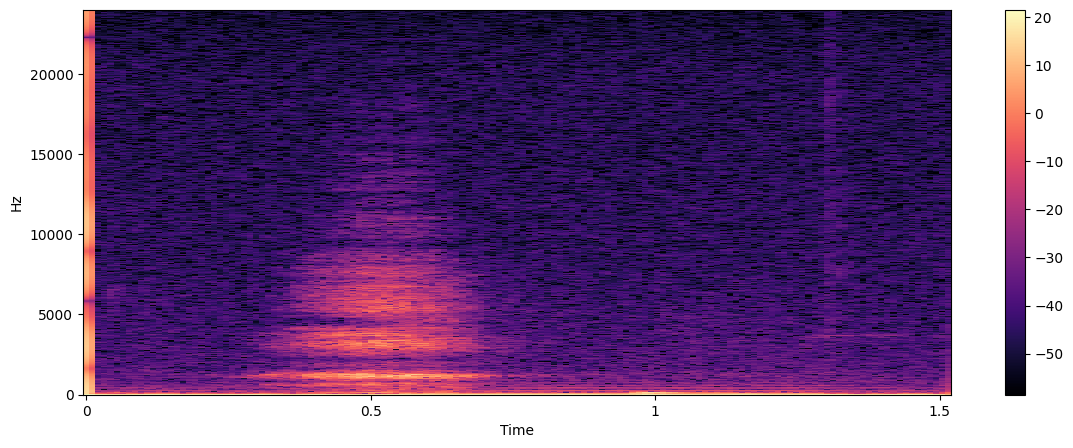

In [ ]:
# spectrogram

X = librosa.stft(data) #short-time Fourier transform (STFT)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

(143,)


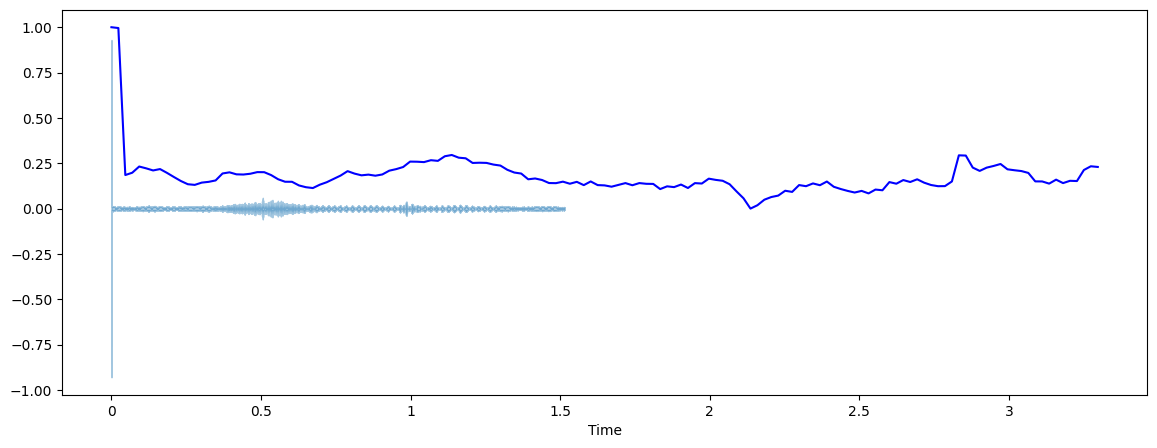

In [ ]:
#Features Analysis, Spectral Centroid
import sklearn.preprocessing


spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sr)[0]
print(spectral_centroids.shape)

#computing the time variable for visualization
plt.figure(figsize=(14,5))
frames = range(len(spectral_centroids))
t= librosa.frames_to_time(frames)

#normalizing the spectral centroids for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=0)
#plotting the spectral centroids along the waveform
librosa.display.waveshow(data, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

In [ ]:
import speech_recognition as sr

def list_microphones():
    for i, mic in enumerate(sr.Microphone.list_microphone_names()):
        print(f"{i}: {mic}")

def choose_microphone():
    print("Please choose a microphone from the list:")
    list_microphones()
    mic_index = int(input("Enter the microphone index: "))
    return mic_index

def record_text(mic_index, recognizer):
    with sr.Microphone(device_index=mic_index) as source:
        print("Say something!")
        audio = recognizer.listen(source)
    return audio

def main():
    recognizer = sr.Recognizer()
    chosen_microphone = choose_microphone()

    try:
        audio = record_text(chosen_microphone, recognizer)
        text = recognizer.recognize_google(audio, language='ar')
        print("You said: " + text)
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")

if __name__ == "__main__":
    main()


  Using cached playsound-1.3.0.tar.gz (7.7 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=da608854c316515dca7add2714df665da519515f1ef45d678cc0b099f8335603
  Stored in directory: /Users/saraabdelhafid/Library/Caches/pip/wheels/cf/42/ff/7c587bae55eec67b909ca316b250d9b4daedbf272a3cbeb907
Successfully built playsound
Note: you may need to restart the kernel to use updated packages.


## 1. Detect Language:

In [ ]:
'''# Function to detect the language of the input text
def detect_language(text):
    return detect(text)'''
# Load the pre-trained fastText model for language identification
fasttext_model = fasttext.load_model('lid.176.bin')

# Function to detect the language of the input text using fastText
def detect_language(text):
    predictions = fasttext_model.predict(text, k=1)  # k=1 returns the top prediction
    language_code = predictions[0][0].replace('__label__', '')
    return language_code

In [ ]:
prompt1 = "Cómo estás hoy"
prompt2 = "Bonjour Speechy"
prompt3 = "Hello Speechy how are you"
prompt4 = "مرحبا سبيشي"

print(f"The detected language1 is: {detect_language(prompt1)}")
print(f"The detected language2 is: {detect_language(prompt2)}")
print(f"The detected language3 is: {detect_language(prompt3)}")
print(f"The detected language4 is: {detect_language(prompt4)}")

The detected language1 is: es
The detected language2 is: fr
The detected language3 is: en
The detected language4 is: ar


## 2. Generate Response:


In [ ]:
'''# Assuming we have a function `generate_response` that uses GPT-4

# Function to generate a response using a multilingual model
'' 'def generate_response(prompt, language):
    # For simplicity, assume we're using a multilingual variant of GPT-4 or similar
    # Load a pre-trained model and tokenizer
    model_name = 'gpt-4-multilingual'
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    print(tokenizer)
    model = GPT2LMHeadModel.from_pretrained(model_name)

    # Encode the input prompt
    inputs = tokenizer.encode(prompt, return_tensors='pt')

    # Generate a response
    outputs = model.generate(inputs, max_length=100, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response'' '



# Function to generate a response using a multilingual translation model
def generate_response(prompt, language):
    # Load the pre-trained model and tokenizer for translation
    model_name = 'Helsinki-NLP/opus-mt-mul-en'
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    print(tokenizer)

    ' ''model = MarianMTModel.from_pretrained(model_name)

    # Translate prompt to English for processing
    translated = tokenizer.encode(prompt, return_tensors='pt')
    translated_text = model.generate(translated)
    translated_prompt = tokenizer.decode(translated_text[0], skip_special_tokens=True)

    # Here you would use a GPT model to generate a response in English
    # For simplicity, let's mock this step with a simple response
    response_in_english = f"This is a generated response for: {translated_prompt}"

    # Translate the response back to the original language
    back_translated = tokenizer.encode(response_in_english, return_tensors='pt')
    back_translated_text = model.generate(back_translated)
    final_response = tokenizer.decode(back_translated_text[0], skip_special_tokens=True)
    
    return final_response'' '




# Example usage
prompt = "hello Speechy"
language = detect_language(prompt)
print(f"hello Speechy is in {language}")

generate_response(prompt, language)
#response = generate_response(prompt, language)
#print(response)'''

'# Assuming we have a function `generate_response` that uses GPT-4\n\n# Function to generate a response using a multilingual model\n\'\' \'def generate_response(prompt, language):\n    # For simplicity, assume we\'re using a multilingual variant of GPT-4 or similar\n    # Load a pre-trained model and tokenizer\n    model_name = \'gpt-4-multilingual\'\n    tokenizer = GPT2Tokenizer.from_pretrained(model_name)\n    print(tokenizer)\n    model = GPT2LMHeadModel.from_pretrained(model_name)\n\n    # Encode the input prompt\n    inputs = tokenizer.encode(prompt, return_tensors=\'pt\')\n\n    # Generate a response\n    outputs = model.generate(inputs, max_length=100, num_return_sequences=1)\n    response = tokenizer.decode(outputs[0], skip_special_tokens=True)\n    return response\'\' \'\n\n\n\n# Function to generate a response using a multilingual translation model\ndef generate_response(prompt, language):\n    # Load the pre-trained model and tokenizer for translation\n    model_name = \'He

## 3. googletrans  Translator

In [ ]:
'''translator = Translator()

# Translate prompt to English
translated_prompt = translator.translate(prompt, src=language, dest='en').text

# Generate response in English
response_in_english = generate_response(translated_prompt)

# Translate response back to the detected language
final_response = translator.translate(response_in_english, src='en', dest=language).text
print(final_response)
'''

"translator = Translator()\n\n# Translate prompt to English\ntranslated_prompt = translator.translate(prompt, src=language, dest='en').text\n\n# Generate response in English\nresponse_in_english = generate_response(translated_prompt)\n\n# Translate response back to the detected language\nfinal_response = translator.translate(response_in_english, src='en', dest=language).text\nprint(final_response)\n"

In [ ]:
'''
import os
import openai
import langid
from translate import Translator

# Set your OpenAI API key
openai.api_key = os.getenv('OPENAI_API_KEY')

# Function to detect the language of the input text using langid
def detect_language(text):
    lang, _ = langid.classify(text)
    return lang

# Function to translate text using the translate library
def translate_text(text, from_lang, to_lang):
    translator = Translator(from_lang=from_lang, to_lang=to_lang)
    return translator.translate(text)

# Function to generate a response using OpenAI's GPT-3/4
def generate_response(prompt, language):
    # Translate the prompt to English if it's not in English
    if language != 'en':
        prompt_in_english = translate_text(prompt, language, 'en')
    else:
        prompt_in_english = prompt
    
    # Generate a response using OpenAI's GPT-3/4
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt_in_english,
        max_tokens=150
    )
    
    response_in_english = response.choices[0].text.strip()
    
    # Translate the response back to the original language if it's not in English
    if language != 'en':
        final_response = translate_text(response_in_english, 'en', language)
    else:
        final_response = response_in_english
    
    return final_response

# Example usage
prompts = ["Cómo estás hoy", "bonjour Speechy", "Hello Speechy how are you", "مرحبا سبيشي"]
for i, prompt in enumerate(prompts, 1):
    language = detect_language(prompt)
    print(f"Detected language for prompt {i}: {language}")
    response = generate_response(prompt, language)
    print(f"Response {i}: {response}")
'''

'\nimport os\nimport openai\nimport langid\nfrom translate import Translator\n\n# Set your OpenAI API key\nopenai.api_key = os.getenv(\'OPENAI_API_KEY\')\n\n# Function to detect the language of the input text using langid\ndef detect_language(text):\n    lang, _ = langid.classify(text)\n    return lang\n\n# Function to translate text using the translate library\ndef translate_text(text, from_lang, to_lang):\n    translator = Translator(from_lang=from_lang, to_lang=to_lang)\n    return translator.translate(text)\n\n# Function to generate a response using OpenAI\'s GPT-3/4\ndef generate_response(prompt, language):\n    # Translate the prompt to English if it\'s not in English\n    if language != \'en\':\n        prompt_in_english = translate_text(prompt, language, \'en\')\n    else:\n        prompt_in_english = prompt\n    \n    # Generate a response using OpenAI\'s GPT-3/4\n    response = openai.Completion.create(\n        engine="text-davinci-003",\n        prompt=prompt_in_english,\n 

In [ ]:
#### INPUT
#get_input_audio 1

#audio_to_text_input 1
#save_text_to_file 1

#### OUTPUT
#generate_output_text 0
#save_text_to_file 1
#text_to_speech_autput 1
#play_output 1

In [ ]:
#!/bin/python3

import math
import os
import random
import re
import sys

#
# Complete the 'plusMinus' function below.
#
# The function accepts INTEGER_ARRAY arr as parameter.
#

def plusMinus(arr):
    p_num=0
    n_num=0
    z_num=0
    for x in arr:
        if x == 0:
            z_num+=1
        elif x>=0 and x<=100:
            p_num+=1
        elif x<=0 and x>= -100:
            n_num +=1
        else:
            break
    print(p_num/len(arr)) 
    print(n_num/len(arr))
    print(z_num/len(arr))

    

if __name__ == '__main__':
    n = int(input().strip())

    arr = list(map(int, input().rstrip().split()))

    plusMinus(arr)


0.5
0.3333333333333333
0.16666666666666666


In [ ]:
arr = [1, 2, 3, 4, 5]

for x in arr:
    print(x)

1
2
3
4
5


In [24]:
#!/bin/python3

import math
import os
import random
import re
import sys

#
# Complete the 'miniMaxSum' function below.
#
# The function accepts INTEGER_ARRAY arr as parameter.
#

def miniMaxSum(arr):
    # Write your code here
    min_sum=0
    max_sum=0
    i=0
    j=0
    max_n =max(arr)
    min_n =min(arr)
    #print("min_n=",min_n," max_n=",max_n)
    for x in arr:
        if x < max_n:
            min_sum +=x
            #print("min_sum + ",x," = ",min_sum)
            i += 1
        if x > min_n:
            max_sum += x
            #print("max_sum + ",x," = ",max_sum)
            j += 1
    if i<len(arr)-1:
        min_sum += max_n*(len(arr)-1 - i)
    if j<len(arr)-1:
        max_sum += min_n*(len(arr)-1 - j)
    print(min_sum, max_sum)

arr = [1, 3 ,5, 7,9]        
miniMaxSum(arr)
#if __name__ == '__main__':

#    arr = list(map(int, input().rstrip().split()))

#    miniMaxSum(arr)


16 24
